In [114]:
#Manejo de datos
import pandas as pd
import numpy as np

#Preprocesamiento de entrenamiento y prueba
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score

# Para menejo de PLN
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
import re
import nltk
from nltk.corpus import stopwords

#Modelado y metricas
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report

#Gráficas
import matplotlib.pyplot as plt

#Quitar avisos molestos
import warnings
from sklearn.exceptions import FitFailedWarning

# Ignorar ciertas advertencias
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FitFailedWarning)
warnings.filterwarnings('ignore', category=FutureWarning, module='xgboost.*')

In [92]:
#Leer la base de datos con los nombres de los archivos
df = pd.read_excel("textos.xlsx")

In [94]:
df

,N.,ARCHIVO,TEXTO,ESTADO
0,0,1. Cristian Parrado_Todos.pdf,Acta Individual de Grado HECOLEGIO LOS COMUNER...,1
1,1,1. CUENCA GOMEZ MARIA ALEJANDRA - CERTIFICADO ...,Al responder cite este número EXT_S23‐00007520...,1
2,2,1. Mariana Palacios Marin.pdf,Al responder cite este número EXT_S20‐00005079...,1
3,3,10 JULIANA MARCELA SALAZAR CIFUENTES.pdf,Al responder cite este número EXT_S23‐00001903...,1
4,4,1000004977 - DANIELA CORTES RONCANCIO.pdf,"ps seme, Adhesivo Copla: AS PO CivilORGANIZACI...",0
...,...,...,...,...
1700,1700,Yuly Alejandra Guerrero Santamaria.pdf,DOLOMELS CIMDIRAMARCE BOGOTA DT —__ €_—__—_——a...,0
1701,1701,YURADNY ESCOBAR MORENO.pdf,El futuroMininteriores de todosAl responder ci...,1
1702,1702,Yuris Yavany Yate Piña.pdf,Al responder cite este número EXT_S23‐00004488...,1
1703,1703,YURY KATHERINE PRIETO ACERO.pdf,,0


In [95]:
#Descargar los stop words convencionales de nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\57350\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [96]:
#Definir una función que reprocese los textos
def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = str(text)
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    stop_words = set(stopwords.words('spanish'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

In [97]:
#Se guardan los textos reprocesados
df['TEXTO2'] = df['TEXTO'].apply(preprocess_text)

In [98]:
#Se definen los conjuntos de entrnamiento y test
y = df['ESTADO']
X_train, X_test, y_train, y_test = train_test_split(df['TEXTO2'], y, test_size=0.33, random_state=53)

In [100]:
# Vectorización con CountVectorizer
count_vectorizer = CountVectorizer()
count_train = count_vectorizer.fit_transform(X_train.values)
count_test = count_vectorizer.transform(X_test.values)

In [102]:
# Definición de parámetros para GridSearchCV
param_grid_nb = {'alpha': [0.01, 0.1, 1, 10],'fit_prior': [True, False]}
param_grid_lr = {'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']}
param_grid_svc = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
param_grid_rf = {'n_estimators': [100, 200], 'max_features': ['sqrt', 'log2']}
param_grid_xgb = {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1, 0.5]}

# Configuración de GridSearchCV para cada modelo
models_params = {
    
    ('Logistic Regression', LogisticRegression(solver='liblinear')): param_grid_lr,
    ('Multinomial Naive Bayes', MultinomialNB()): param_grid_nb,
    ('SVM', SVC()): param_grid_svc,
    ('Random Forest', RandomForestClassifier()): param_grid_rf,
    ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')): param_grid_xgb
}

# Ejecución de GridSearchCV para cada modelo y recolección de datos
train_scores = []
test_scores = []
models = []
best_estimators={}

for (name, model), params in models_params.items():
    grid_search = GridSearchCV(model, params, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(count_train, y_train)
    models.append(name)
    train_scores.append(grid_search.cv_results_['mean_test_score'])
    best_estimators[name] = grid_search.best_estimator_
    test_score = best_estimators[name].score(count_test, y_test)
    test_scores.append(test_score)
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best cross-validation score for {name}: {grid_search.best_score_}")
    print(f"Test score for {name}: {test_score}")

Best parameters for Logistic Regression: {'C': 1, 'penalty': 'l1'}
Best cross-validation score for Logistic Regression: 0.9903738604152302
Test score for Logistic Regression: 0.9946714031971581
Best parameters for Multinomial Naive Bayes: {'alpha': 0.01, 'fit_prior': True}
Best cross-validation score for Multinomial Naive Bayes: 0.9833601470926222
Test score for Multinomial Naive Bayes: 0.9911190053285968
Best parameters for SVM: {'C': 0.1, 'kernel': 'linear'}
Best cross-validation score for SVM: 0.9886233049873592
Test score for SVM: 0.9911190053285968
Best parameters for Random Forest: {'max_features': 'sqrt', 'n_estimators': 100}
Best cross-validation score for Random Forest: 0.9816172527388339
Test score for Random Forest: 0.9893428063943162
Best parameters for XGBoost: {'learning_rate': 0.1, 'n_estimators': 100}
Best cross-validation score for XGBoost: 0.991247222860645
Test score for XGBoost: 0.9946714031971581


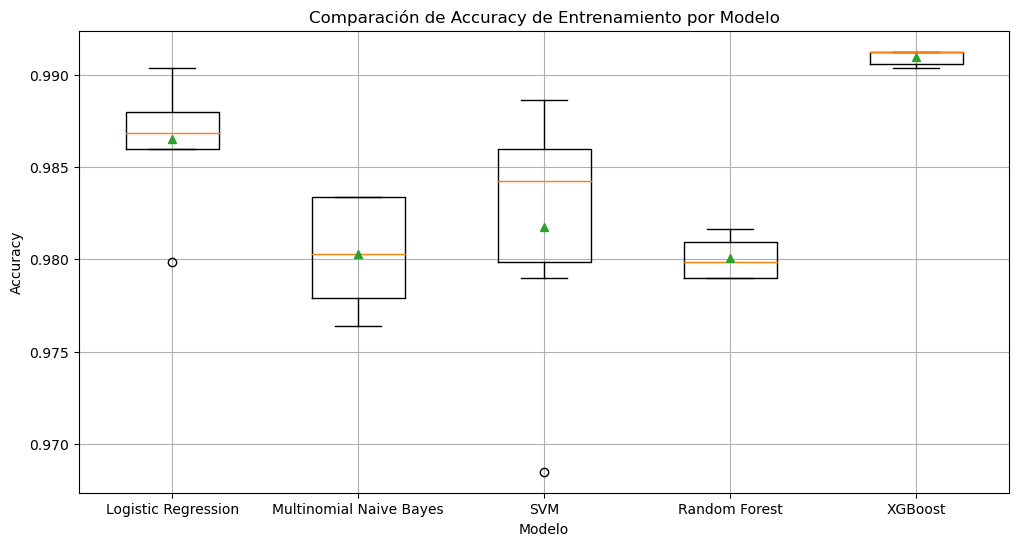

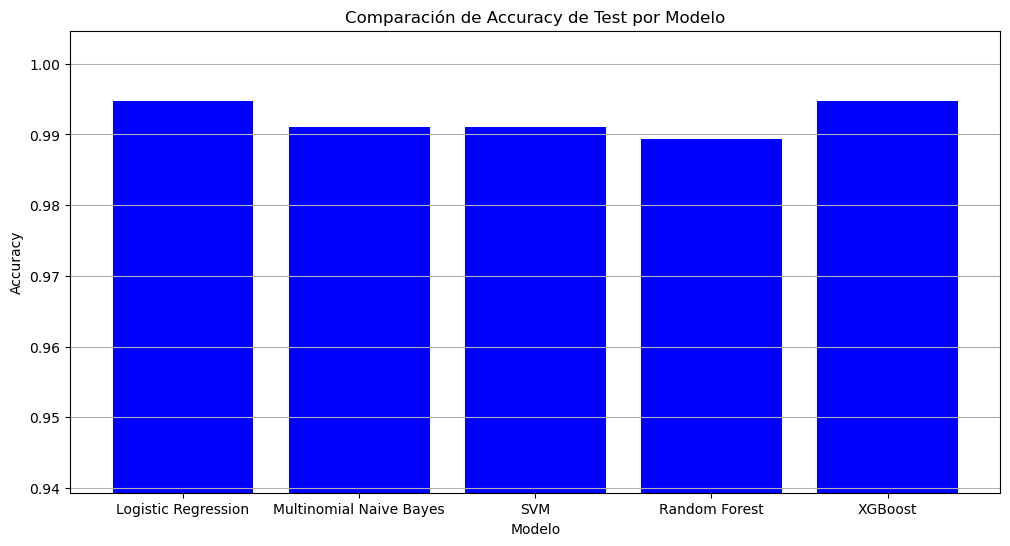

In [103]:
# Gráfico de cajas para ACC de entrenamiento
plt.figure(figsize=(12, 6))
plt.boxplot(train_scores, labels=models, showmeans=True)
plt.title('Comparación de Accuracy de Entrenamiento por Modelo')
plt.ylabel('Accuracy')
plt.xlabel('Modelo')
plt.grid(True)
plt.show()

# Gráfico de barras para ACC de test
plt.figure(figsize=(12, 6))
plt.bar(models, test_scores, color='blue')
plt.title('Comparación de Accuracy de Test por Modelo')
plt.ylabel('Accuracy')
plt.xlabel('Modelo')
plt.ylim([min(test_scores) - 0.05, max(test_scores) + 0.01])  # Ajustar límites para mejor visualización
plt.grid(True, axis='y')
plt.show()

In [105]:
#Dado que el mejor desempeño lo tiene el XGB, predecimos con ese
test_score_xgb = best_estimators["XGBoost"].predict(count_test)

In [106]:
print(len(test_score_xgb))
print(len(X_test))
print(len(y_test))

563
563
563


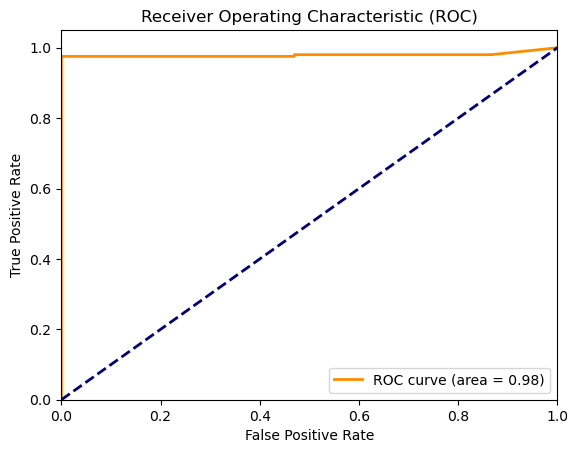

Matriz de confusión:
[[359   1]
 [  2 201]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       360
           1       1.00      0.99      0.99       203

    accuracy                           0.99       563
   macro avg       0.99      0.99      0.99       563
weighted avg       0.99      0.99      0.99       563



In [117]:
#Observamos medidas de desempeño en la clasificación

y_pred_proba = best_estimators["Multinomial Naive Bayes"].predict_proba(count_test)[:, 1] 

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)



# Matriz de confusión
y_pred = best_estimators["Logistic Regression"].predict(count_test)
conf_matrix = confusion_matrix(y_test, y_pred)


classification_rep = classification_report(y_test, y_pred)

# Visualización de la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Visualización de la matriz de confusión
print("Matriz de confusión:")
print(conf_matrix)

print(classification_rep)

In [107]:
#Guardamos la clasificación predica, el texto original y la etiqueta original para comparar manualmente.
data_resultados = {
    'X_train': X_test,
    'y_test': y_test,
    'test_score_xgb': test_score_xgb
}

df_resultados = pd.DataFrame(data_resultados)

In [110]:
df_resultados

,X_train,y_test,test_score_xgb
1368,república colombiax salud total civilcor isso ...,0,0
1115,corregistraduríanacional civilo registro civil...,0,0
495,suscritoa coordinadora grupo investigacion reg...,1,1
1648,suscritoa coordinadora grupo investigacion reg...,1,1
1680,responder cite número ext_ssidacnadacnla direc...,1,1
...,...,...,...
1375,pan dl da tactomorganizacion electoral poregis...,0,0
278,república colombia eidentificación personal cé...,0,0
773,suscritoa coordinadora grupo investigacion reg...,1,1
613,responder cite número ext_ssidacnadacnla direc...,1,1


In [109]:
#Guardamos en exel el df
df_resultados.to_excel("XGB.xlsx")